Risk - constant one as choosing A wrongfully and second as the acc
Temperature - constatnt temp
Temperature "Adaptive" - Try different temp values on the cal set and take the best (maybe use pen as val set)

Risk - As a function, try a simple model for tuning the risk

Maybe add a naive option (without google's procedure)

In [1]:
import os
SLURM_PATH = '/home/yandex/MLWG2025/amitr5'
CACHE_DIR = '' 

if SLURM_PATH in os.getcwd():
        CACHE_DIR = f'{SLURM_PATH}/tmp/hf_cache' 
        os.makedirs(CACHE_DIR, exist_ok=True)
        os.environ["PIP_PATH"] = f"{SLURM_PATH}/BaryGNN/anaconda3/envs/conf/bin/pip"
        os.environ["TEMP_DIR"] = CACHE_DIR
        os.environ["HF_HOME"] = CACHE_DIR
        os.environ["TRANSFORMERS_CACHE"] = CACHE_DIR
        os.environ["HF_DATASETS_CACHE"] = CACHE_DIR
        # Hugging Face uses HUGGINGFACE_HUB_CACHE (HF_HUB_CACHE is ignored)
        os.environ["HUGGINGFACE_HUB_CACHE"] = CACHE_DIR
        os.environ["TMPDIR"] = CACHE_DIR
        os.environ["XDG_CACHE_HOME"] = CACHE_DIR
        # os.environ["TOKENIZERS_PARALLELISM"] = "false"


In [2]:

# Imports #
import numpy as np
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, AutoModelForSeq2SeqLM, AutoTokenizer
import torch
import os
import pandas as pd
# from datasets import load_dataset
# import torch.nn.functional as F
from tqdm.auto import tqdm
# Project imports #

import utils
utils.reload('utils')
from mind2web.dataloader import build_datasets_dict, subsample_by_annotation ,MultiChoiceDataset


# sys.path.append('./Mind2Web/src')

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/transformers/utils/hub.py:110: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


utils- reloaded


In [61]:
utils.reload('mind2web.dataloader')
tokenizer = AutoTokenizer.from_pretrained("google/flan-t5-xl", cache_dir=CACHE_DIR)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "osunlp/MindAct_ActionPrediction_flan-t5-xl"

model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=CACHE_DIR, device_map="auto")
model.eval();


id2split = MultiChoiceDataset.id2split
ds_dict = build_datasets_dict(id2split.values(),cache_dir=CACHE_DIR);

mind2web.dataloader- reloaded


/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/yandex/MLWG2025/amitr5/BaryGNN/anaconda3/envs/conf/lib/python3.13/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['decoder.embed_tokens', 'encoder.embed_tokens']
  warnings.warn(


Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

In [200]:
utils.reload('mind2web.dataloader')
from mind2web.dataloader import subsample_by_annotation, MultiChoiceDataset, MultiChoiceDatasetRandom
cal_dict, pen_dict, test_dict = {}, {}, {}
seed = 42
frac = 0.2
num_candidates=5
max_context_len=512

for split, test_split in ds_dict.items():
    cal_set, test_set = subsample_by_annotation(test_split, frac=frac, seed=seed)
    # cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    
    test_set,_ = subsample_by_annotation(test_split, frac=0.1, seed=seed)
    
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    # pen_dict[split] = MultiChoiceDataset(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    # )

    test_dict[split] = MultiChoiceDataset(
        test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len,cache_prompt=True, cache_tokenized=True
    )

    
    # cal_dict[split] = MultiChoiceDatasetRandom(
    #     cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)
    # pen_dict[split] = MultiChoiceDatasetRandom(
    #     pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

    # test_dict[split] = MultiChoiceDatasetRandom(
    #     test_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len)

mind2web.dataloader- reloaded


In [55]:
utils.reload('utils.helpers')
cal_df = pd.read_pickle('cal_df.pkl')
cal_df = utils.helpers.add_eval_columns(cal_df)
label_map = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5}
y_cal = cal_df["target_label"].map(label_map)

alpha = 0.1
lambda_grid = np.linspace(0.0, 1.0, 2000)

best_lambda, results = utils.helpers.tune_lambda_group_risk(
    cal_df=cal_df,
    y_cal=y_cal,
    alpha=alpha,
    lambda_grid=lambda_grid,
)

best = results[best_lambda]
best, best_lambda

utils.helpers- reloaded
LambdaResult(lam=0.8939469734867433, risk_hat=np.float64(0.09), acc=0.8927335640138409, recall=0.25806451612903225)


(LambdaResult(lam=0.8939469734867433, risk_hat=np.float64(0.09), acc=0.8927335640138409, recall=0.25806451612903225),
 0.8939469734867433)

In [181]:
# results_df
MultiChoiceDataset.choice2token_id

{'A': 71, 'B': 272, 'C': 205, 'D': 309, 'E': 262, 'F': 377}

In [251]:
utils.reload('utils.helpers')
utils.reload('mind2web.dataloader')
utils.reload('utils.llm_utils')

# full_df = pd.read_pickle('data_set_all.pkl')
# full_df["test_split"] = full_df["test_split"].astype(str)
# cal_dict
# df = utils.helpers.filter_to_calibration_actions(full_df, cal_dict)

utils.helpers- reloaded
mind2web.dataloader- reloaded
utils.llm_utils- reloaded


In [236]:
def get_threshold(cal_df, alpha: float):
    # google's nonconformity score
    cal_grouped = cal_df.groupby('annotation_id')
    score_per_group = 1 - cal_grouped['target_prob'].min()
    
    N = len(score_per_group)
    k = int(np.ceil((N + 1) * (1 - alpha)))
    sorted_scores = np.sort(score_per_group.values)
    threshold = sorted_scores[k - 1]
    return threshold


def split_to_cal_penalty(cal_set, seed=0):
    cal_set, pen_set = subsample_by_annotation(cal_set, frac=0.5, seed=seed)
    cal_dict[split] = MultiChoiceDataset(
        cal_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )
    pen_dict[split] = MultiChoiceDataset(
        pen_set, tokenizer, num_candidates=num_candidates, max_context_len=max_context_len, cache_prompt=True, cache_tokenized=True
    )

    return cal_dict, pen_dict

def evaluation(cal_set, test_dict, full_df, model, tokenizer, seed=0):
    
    eval_to = 'crc'

    full_df["test_split"] = full_df["test_split"].astype(str)
    cal_dict, pen_dict = split_to_cal_penalty(cal_set, seed=seed)
    # cal_df = utils.helpers.filter_to_calibration_actions(full_df, cal_dict)
    pen_df = utils.helpers.filter_to_calibration_actions(full_df, pen_dict)
    best_lambda, results = utils.helpers.best_lambda_from_df(cal_df=pen_df, alpha=0.2)
    pen_df['lambda'] = best_lambda
    pen_df = utils.helpers.add_eval_columns(pen_df, to_save=True, save_path=f'{eval_to}/pen/pen_{seed}.pkl')

    cal_df = utils.llm.evaluate_splits(cal_dict, model, tokenizer, shrinkage=best_lambda)
    cal_df['lambda'] = best_lambda
    cal_df = utils.helpers.add_eval_columns(cal_df, to_save=True, save_path=f'{eval_to}/cal/cal_{seed}.pkl')
    
    threshold = get_threshold(cal_df, alpha=0.1)
    result_df = utils.llm.evaluate_splits(test_dict, model, tokenizer, shrinkage=best_lambda)
    result_df['lambda'] = best_lambda
    result_df['threshold'] = threshold
    result_df = utils.helpers.add_eval_columns(result_df, threshold=threshold, to_save=True, save_path=f'{eval_to}/test/test_{seed}.pkl')
    return result_df

    

In [237]:
results = evaluation(cal_set, test_dict, full_df, model, tokenizer)

Evaluating split: test_task
Evaluating split: test_domain
Evaluating split: test_website
Evaluating split: test_task
Evaluating split: test_domain
Evaluating split: test_website


Threshold: 0.984556426294148,187


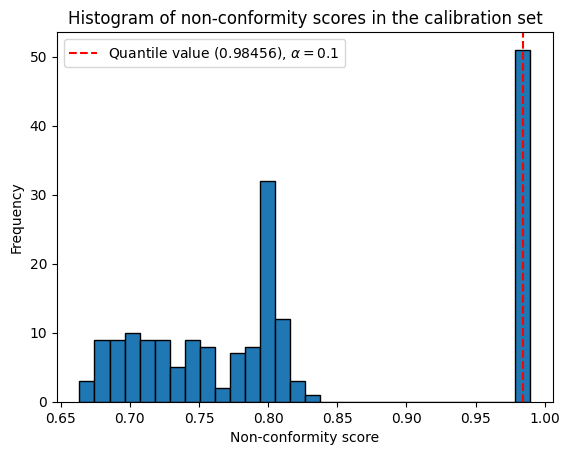

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [247]:
# results
cal_df = pd.read_pickle('results/crc/cal/cal_0.pkl')
pen_df = pd.read_pickle('results/crc/pen/pen_0.pkl')
test_df = pd.read_pickle('results/crc/test/test_0.pkl')

cal_df = utils.helpers.add_eval_columns(cal_df, logits_temp=16, to_save=False)

threshold = get_threshold(cal_df, alpha=0.1)
cal_grouped = cal_df.groupby('annotation_id')
score_per_group = 1 - cal_grouped['target_prob'].min()
print(f'Threshold: {threshold},{len(score_per_group)}')
utils.plot.nonconformity_histogram(score_per_group, threshold=threshold)

In [248]:
test_df = utils.helpers.add_eval_columns(test_df, threshold=threshold, logits_temp=6, to_save=False)
test_df['pred_set_size'].mean()
best_lambda, results = utils.helpers.best_lambda_from_df(cal_df=pen_df)
best_lambda

0.8718718718718719

In [250]:
test_df.head()

test_df['pred_label'].value_counts()
# test_df['correct'].mean()
# utils.plot.nonconformity_histogram(score_per_group, threshold)

pred_label
B    453
F    137
C     11
D     10
E      8
Name: count, dtype: int64

rand_idx
0    1101
Name: count, dtype: int64

In [61]:
# out['scores'][0].shape
out['scores'][3].shape

torch.Size([1, 32128])

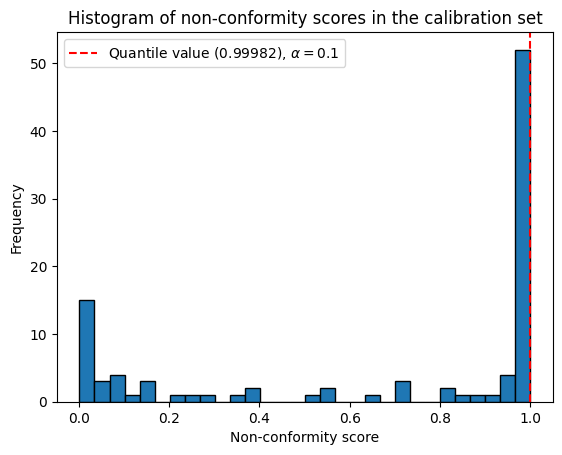

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


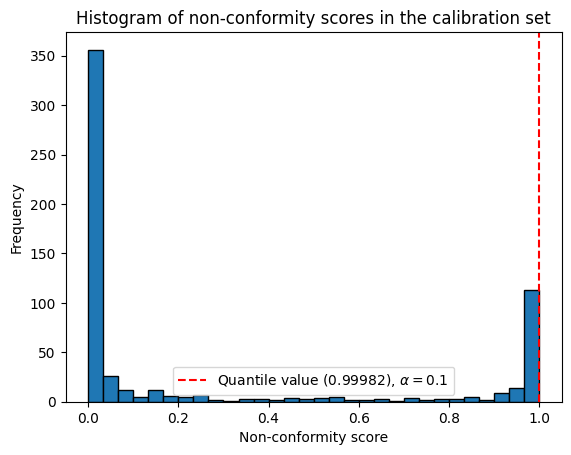

A good predictor should have low non-conformity scores, concentrated at the left side of the figure


In [118]:
utils.plot.nonconformity_histogram(score_per_group, threshold)
utils.plot.nonconformity_histogram(1-cal_df['true_prob'], threshold)